In [22]:
import numpy as np
from bs4 import BeautifulSoup as bs
import pandas as pd

import pandas_datareader as pdr
from pandas_datareader import data as wb
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams.update({'font.family' : 'sans'})
sm, med, lg = 10, 15, 20
plt.rc('font', size = sm)         # controls default text sizes
plt.rc('axes', titlesize = med)   # fontsize of the axes title
plt.rc('axes', labelsize = med)   # fontsize of the x & y labels
plt.rc('xtick', labelsize = sm)   # fontsize of the tick labels
plt.rc('ytick', labelsize = sm)   # fontsize of the tick labels
plt.rc('legend', fontsize = sm)   # legend fontsize
plt.rc('figure', titlesize = lg)  # fontsize of the figure title
plt.rc('axes', linewidth=2)       # linewidth of plot lines


import seaborn as sns
sns.set()

from scipy.optimize import minimize

import itertools
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor as knn
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from mpl_finance import candlestick_ohlc
from tqdm import tqdm_notebook
from pylab import rcParams


import yfinance as yf
from yahoofinancials import YahooFinancials
from urllib.request import urlopen
import requests


import locale, sys 
from datetime import date, datetime, timedelta
import time, csv, json, os, math

from IPython.display import IFrame
# ![img](images/paintcarelogo.png)

import warnings
warnings.filterwarnings('ignore')


print('\n          * * * NO ISSUES - ALL IMPORTS LOADED * * * \n')


          * * * NO ISSUES - ALL IMPORTS LOADED * * * 



# SET INPUTS: (time_series, tickers)

In [2]:
start = datetime(2018, 1, 2)
end = datetime.now()

ticker = 'TSLA'
# ticker = input('Ticker: ')
tickers = [ticker, '^GSPC', '^IXIC', '^DJI']

# Stock_Prediction_Model:

In [18]:
test_size = 0.2
cv_size = 0.2
Nmax = 2

In [19]:
df1 = wb.get_data_yahoo(ticker, start = start)
df1.to_csv('data/stockModelPredict1.csv')
df = pd.read_csv('data/stockModelPredict1.csv')

def get_preds_mov_avg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Using simple moving average.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : list. The predictions for target_col. np.array of length len(df)-offset.
    """
    pred_list = df[target_col].rolling(window = N, min_periods=1).mean() # len(pred_list) = len(df)
    
    # Add one timestep to the predictions
    pred_list = np.concatenate((np.array([np.nan]), np.array(pred_list[:-1])))
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
    
    return pred_list[offset:]

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

num_train = 437
num_cv = 145
num_test = 145
train.shape = (437, 8)
cv.shape = (145, 8)
train_cv.shape = (582, 8)
test.shape = (145, 8)


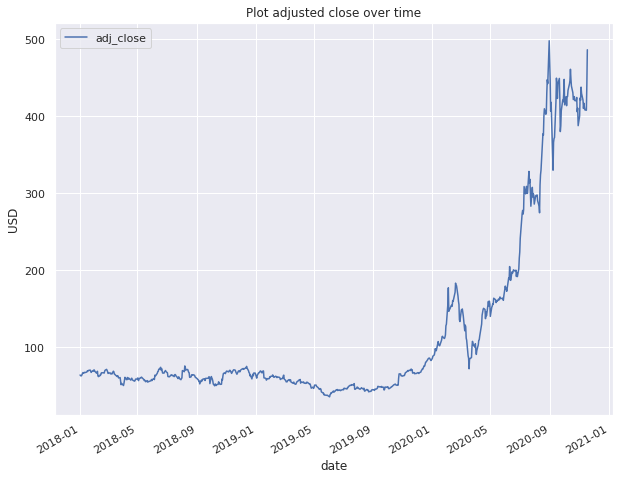

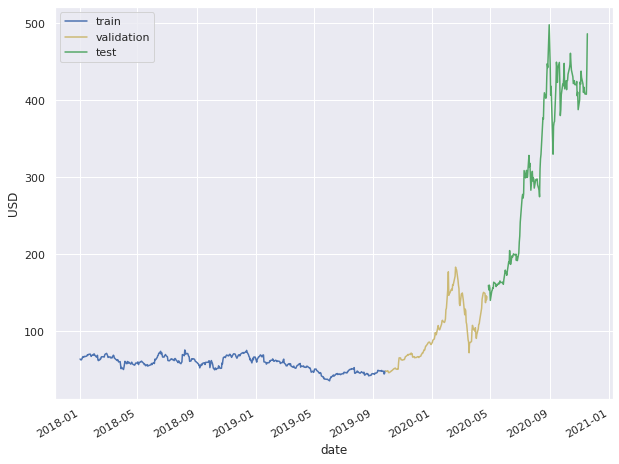

In [20]:
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')
    # Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
    # # Get month of each sample
df['month'] = df['date'].dt.month
    # Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

####################################

df['date'].min(), df['date'].max()
    # Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Plot adjusted close over time')

####################################

    # Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

    # Split into train, cv, and test
train = df[:num_train].copy()
cv = df[num_train:num_train+num_cv].copy()
train_cv = df[:num_train+num_cv].copy()
test = df[num_train+num_cv:].copy()
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

####################################

test['date'].min(), test['date'].max()

### EDA
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD");

## Predict Using Moving Averages:

RMSE = [6.763680469154048, 7.854508860910732]
MAPE = [3.644701812971487, 4.5387318250826825]


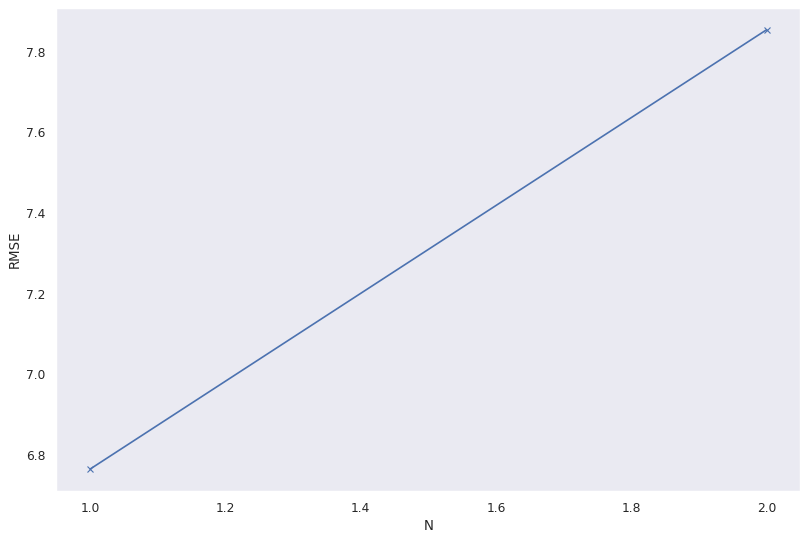

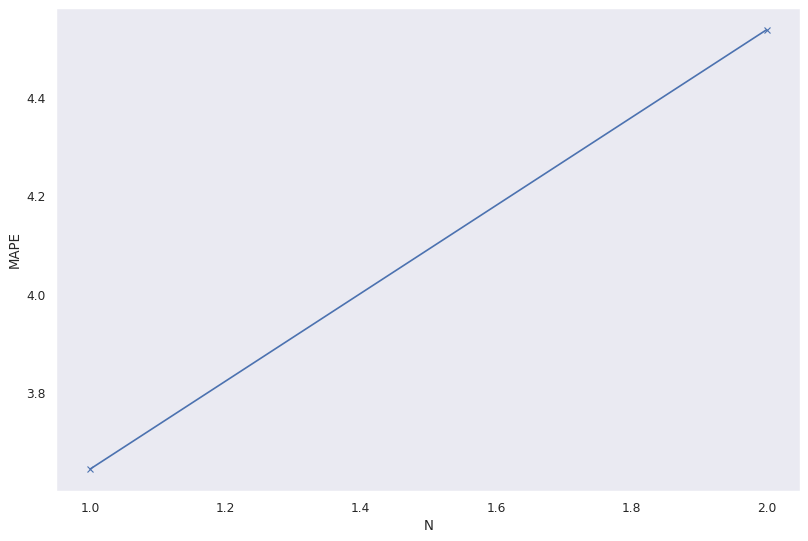

In [24]:
RMSE = []
mape = []
for N in range(1, Nmax+1):
    est_list = get_preds_mov_avg(train_cv, 'adj_close', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['adj_close'])))
    mape.append(get_mape(cv['adj_close'], est_list))
print('RMSE = ' + str(RMSE))
print('MAPE = ' + str(mape))

# Plot RMSE versus N
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')

# Plot MAPE versus N. Note for MAPE smaller better. 
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')

# Set optimum N
N_opt = 1

## Plot Predictions ON Dev Set:

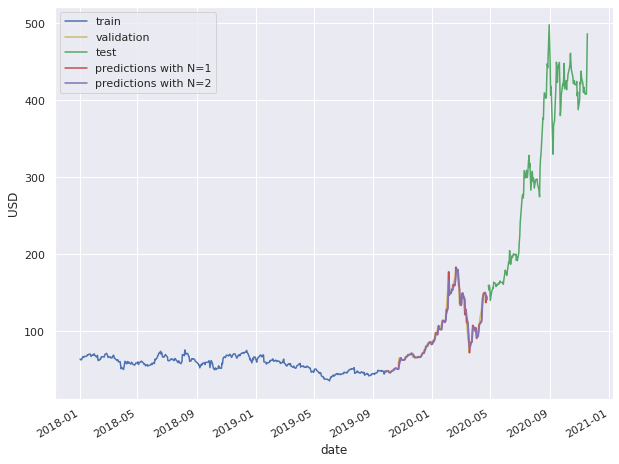

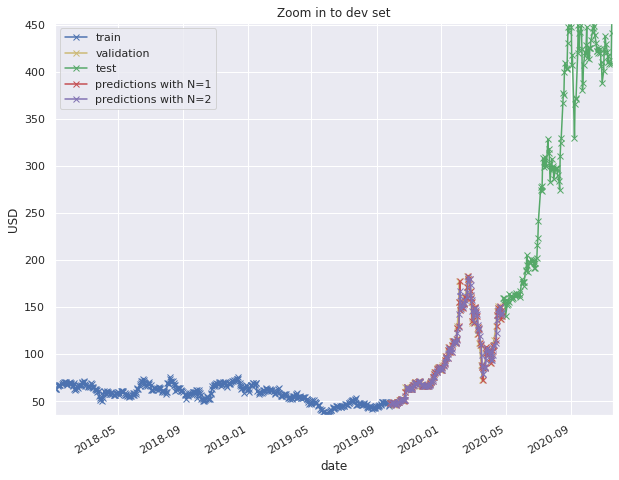

In [39]:
    # Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='m-', grid=True, ax=ax)
ax.legend(
    ['train', 'validation', 'test', 'predictions with N=1','predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")


    # Plot adjusted close over time
rcParams['figure.figsize'] = (10, 8) # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='mx-', grid=True, ax=ax)
ax.legend(
    ['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([start, end])
Min = df['adj_close'].min()
Max = df['adj_close'].max()
step = (Max - Min) / 10
ax.set_ylim([Min, Max - step])
ax.set_title('Zoom in to dev set');

# FINAL MODEL:

RMSE = 17.224
MAPE = 3.571%


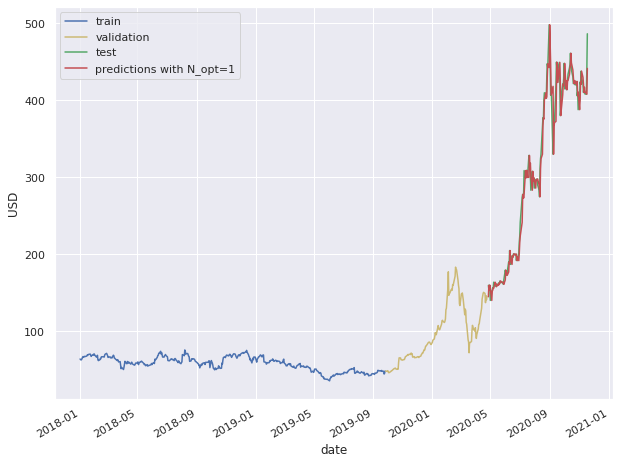

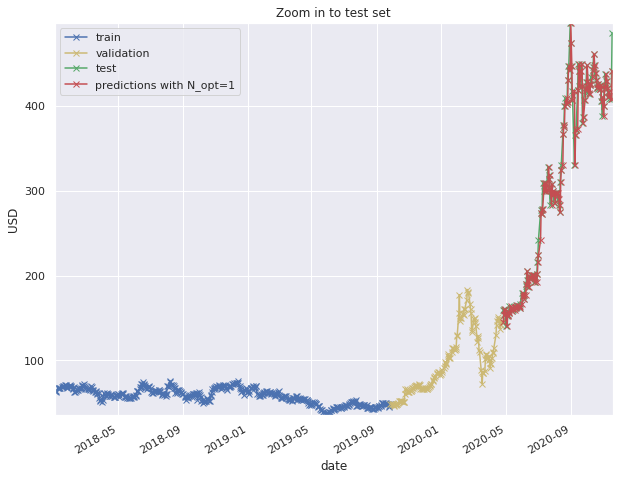

In [46]:
est_list = get_preds_mov_avg(df, 'adj_close', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['adj_close'])))
print("MAPE = %0.3f%%" % get_mape(test['adj_close'], est_list))


# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax.legend(
    ['train', 'validation', 'test', 'predictions with N_opt=1'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
matplotlib.rcParams.update({'font.size': 14})

# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax.legend(
    ['train', 'validation', 'test', 'predictions with N_opt=1'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([start, end])
Min = df['adj_close'].min()
Max = df['adj_close'].max()
ax.set_ylim([Min, Max])
ax.set_title('Zoom in to test set');

# FINDINGS:

In [51]:
# Save as csv
test.to_csv('data/_1011.csv')

# Compare various methods
results_dict = {
    'method': ['Last Value', 'Moving Average', 'Linear Regression', 'XGBoost', 'LSTM'],
    'RMSE': [1.127, 1.27, 1.42, 1.162, 1.164],
    'MAPE(%)': [0.565, 0.64, 0.707, 0.58, 0.583]
    }
results = pd.DataFrame(results_dict)
results.set_index('method')

,RMSE,MAPE(%)
method,,
Last Value,1.127,0.565
Moving Average,1.270,0.640
Linear Regression,1.420,0.707
XGBoost,1.162,0.580
LSTM,1.164,0.583
